In [1]:
import numpy as np
def initialise_lattice(L):
    """intialise a 2D lattice"""
    return np.random.choice([-1,1], size=(L,L))
L=64 # lattice size 

In [2]:
def calc_energy(lattice,J=1):
    """Calculate the total energy of the Ising lattice"""
    energy=0
    L=len(lattice)
    for i in range (L):
        for j in range(L):
            spin=lattice [i,j]
            neighbours= lattice[(i+1) % L,j]+ lattice[i,(j+1) % L] + lattice[(i-1) % L,j] + lattice[i,(j-1)% L]
            energy += -J * spin * neighbours 
    return energy/2 # each pair is counted twice 

In [3]:
def metropolis(lattice, beta, J=1):
    """Perform one Monte Carlo sweep using the Metropolis algorithm."""
    L = len(lattice)
    for _ in range(L**2):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        spin = lattice[i, j]
        neighbours = lattice[(i+1) % L, j] + lattice[i, (j+1) % L] + lattice[(i-1) % L, j] + lattice[i, (j-1) % L]
        dE = 2 * J * spin * neighbours
        if dE < 0 or np.random.rand() < np.exp(-dE * beta):
            lattice[i, j] = -spin


In [4]:
def simulate_ising(L, temp_range, steps_per_temp=5000):
    """Simulate the Ising model for different temperatures."""
    configurations = []
    lattice = initialise_lattice(L)
    for T in temp_range:
        beta = 1 / T
        for step in range(steps_per_temp):
            metropolis(lattice, beta)
        configurations.append(lattice.copy())  # Save configuration after equilibrium
    
    return np.array(configurations)

# Parameters
temp_range = np.linspace(1.5, 3.5, 20)  # Temperature range around Tc
configurations = simulate_ising(L, temp_range)
L= 64 #lattice size 
steps_per_temp=5000 #monte carlo steps 

average_energies = []
for lattice in configurations:
    energy= calc_energy(lattice)
    average_energies.append(energy)

In [5]:
def flatten_lattice(configurations):
    """Flatten the 2D lattice configurations into 1D vectors."""
    num_configs = len(configurations)
    L = configurations.shape[1]
    return configurations.reshape(num_configs, L * L)

flat_configurations = flatten_lattice(configurations)

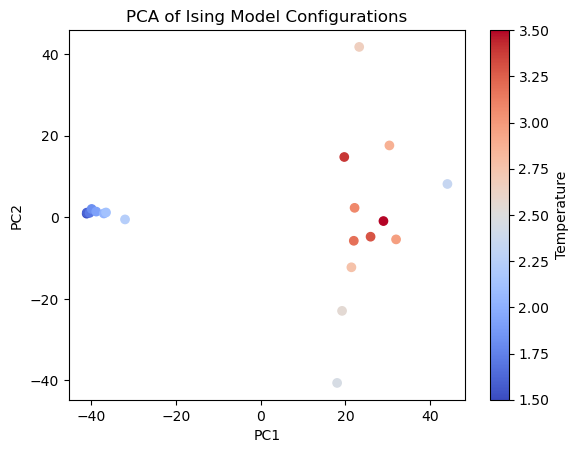

Variance explained by PC1: 0.30
Variance explained by PC2: 0.07


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_configurations)

# Plot the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=temp_range, cmap='coolwarm')
plt.colorbar(label='Temperature')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Ising Model Configurations')
plt.show()

# Check how much variance the components explain
print(f'Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2f}')
print(f'Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2f}')

Based on the scatter plot above the blue points (low temperatures) are clustured tighlty on one side and on the other side the red points are more spread, this likely reflects the physocal nature of the phase transition in the ising model. 

The blue cluster suggests that in the low-temperature regime the system is within the ordered phase. Most of the spins are aligned, leading to a relatively uniform configuration. This homogeneity in spin configurations results in a more compact cluster in the PCA space. The compactness of the blue cluster suggests that configuartions are quite similar at low temperatures, which makes sense because, in the ordered phase, most configurations look alike (with most spins pointing in the same direction). 

In the high temperature regime, the system is in the disordered phase. The spins fluctuate more freely, resulting in a wide variety of configurations. This leads to a more diverse and scattered points in the PCA space, which you see as a spread-out cluster of red points. This spread reflects the fact that, at high temperatures, the system can adopt many different configurations due to thermal agitation, which makes them more spread out in the PCA plot. 

In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize the data before applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(flat_configurations)

# Apply PCA to the scaled data
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

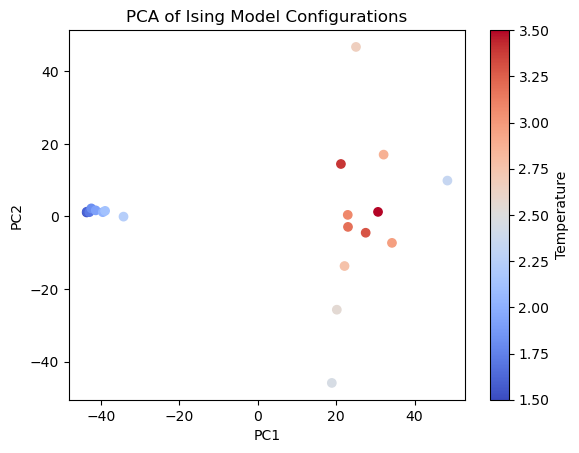

Variance explained by PC1: 0.28
Variance explained by PC2: 0.07


In [8]:
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=temp_range, cmap='coolwarm')
plt.colorbar(label='Temperature')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Ising Model Configurations')
plt.show()

# Check how much variance the components explain
print(f'Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2f}')
print(f'Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2f}')

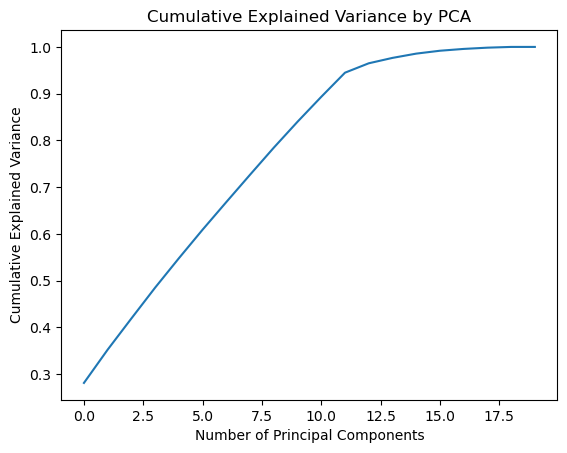

In [9]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.show()

After seeing that the first two components only explained for 34% of the total variance. I wanted to see how many components truly were affecting the variance of my data so I could continue my analysis. After plotting cumaltive variance and seeing that curve begins to flatten out around 17 components i decided to increase the PCA to 17 components instead of the original 2.

In [10]:
# If cumulative variance flattens after 17 components, limit PCA to first 17
pca = PCA(n_components=17)
pca_result = pca.fit_transform(scaled_data)

print(f'Cumulative variance explained by first 17 components: {sum(pca.explained_variance_ratio_):.2f}')

Cumulative variance explained by first 17 components: 1.00


In [11]:
pca = PCA(n_components=17)
pca_result = pca.fit_transform(scaled_data)

print(f'PCA shape: {pca_result.shape}')

PCA shape: (20, 17)


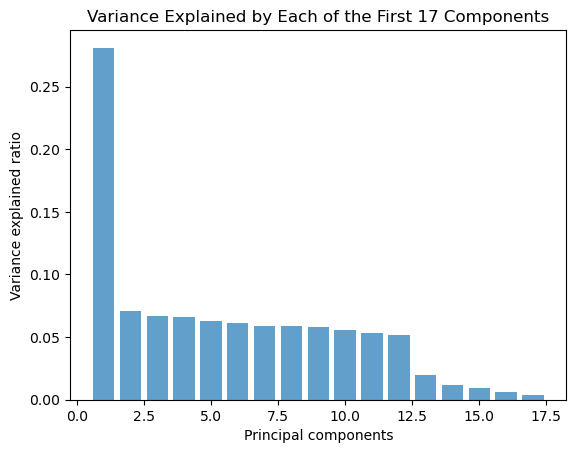

In [12]:
plt.bar(range(1, 18), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.ylabel('Variance explained ratio')
plt.xlabel('Principal components')
plt.title('Variance Explained by Each of the First 17 Components')
plt.show()

After plotting the bar graph it was clear to see that the majority of variance was caused by PC1 and the others had lower variance scores, showing PC1 is the most dominant feature so it is likely relatd to a critical physical quanitity such as magnetisation, which characterises the difference between the ordered and disoreded phases.The smaller variance scores suggest that t the other components are capturing less critical aspects of the system such as local fluctuations and noise. These components likely describe minor variations within phases. 

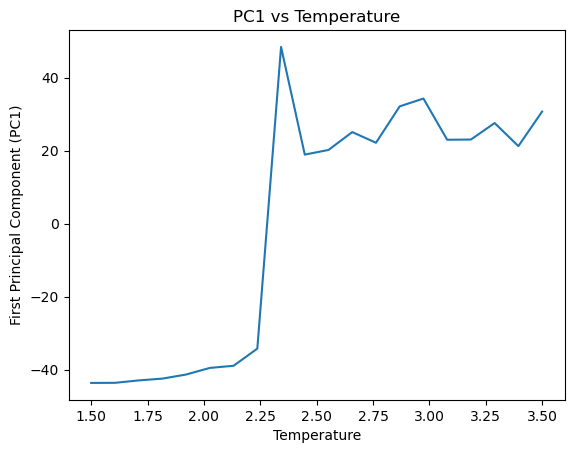

In [13]:
plt.plot(temp_range, pca_result[:, 0])
plt.xlabel('Temperature')
plt.ylabel('First Principal Component (PC1)')
plt.title('PC1 vs Temperature')
plt.show()

Based on the plot of PC1 vs temperature there is another indicator that pc1 us capturing the phase transition in the system. This drop reflects the transition from the ordered phase into the disordered phase. PC1 likely represents an order parameter which is related to magnetisation. In the ordered phase belowed the critical temperature the system has a non-zero magnetization (spins align), leading to a high value of PC1. In the disordered phase above the critical temperature, magnetisation approcahes zero causing PC1 to drop. The sharp change around the critical tenoearure shows that the system exhibits critical behaviour at this temperature, with significant fluctuations and changes in the systems macroscopic properties. 

C:\Users\kevin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kevin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


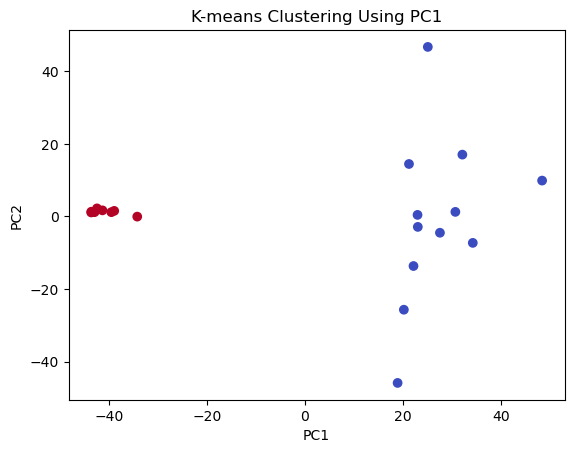

In [14]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(pca_result[:, 0].reshape(-1, 1))  # Use only PC1

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Using PC1')
plt.show()

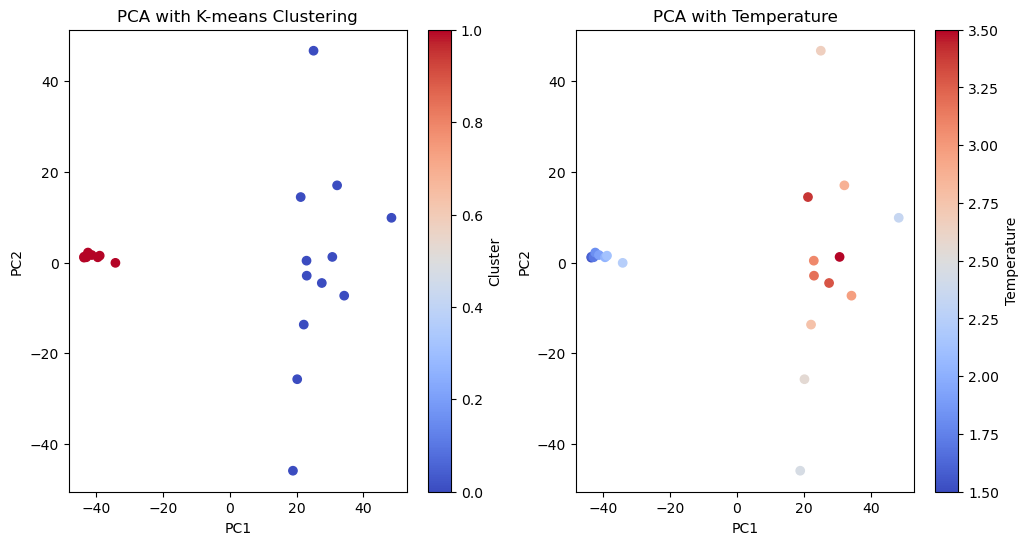

In [15]:
plt.figure(figsize=(12, 6))

# PCA plot with clustering
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='coolwarm')
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with K-means Clustering')

# PCA plot with temperature color mapping
plt.subplot(1, 2, 2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=temp_range, cmap='coolwarm')
plt.colorbar(label='Temperature')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with Temperature')

plt.show()

K-means clustering producing results similar to PCA analysis indicates that the principal components (especially PC1) are capturing the critical features necessary for distinguishing between the ordered and disordered phases.The agreement between PCA and clustering results reinforces the validity of PC1 as a key descriptor of the phase transition. This consistency shows that the dimensionality reduction via PCA aligns with the clustering approach, highlighting the effectiveness of PC1 in capturing the transition.

In [22]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(pca_result, clusters)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.26
Calinski-Harabasz Index: 6.80


Although this is only a moderate silhouette score this is most likely because the silhouette score reflects both the separation between clusters and the cohesion within them. If the disordered phase is spread out or has high variability, this can reduce the overall score, even if the ordered phase is well-clustered. 

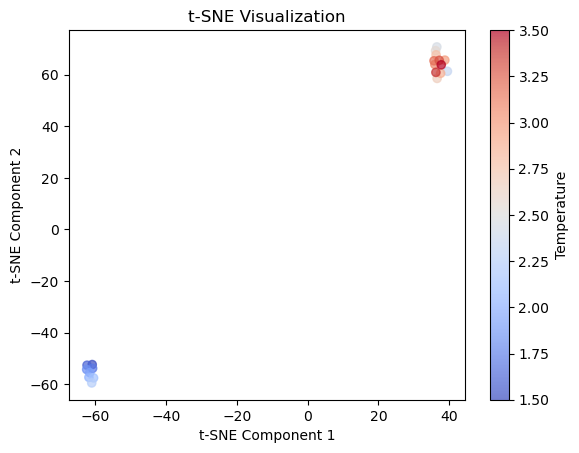

Calinski-Harabasz Index: 9651.00
Silhouette Score: 0.97


In [24]:
from sklearn.manifold import TSNE

components_for_tsne = pca_result[:, :2]
n_samples = components_for_tsne.shape[0]
perplexity_value = min(5, n_samples - 1) 

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_result = tsne.fit_transform(components_for_tsne)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=temp_range, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Temperature')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()


from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(tsne_result, clusters)
print(f'Calinski-Harabasz Index: {ch_score:.2f}')

silhouette_avg = silhouette_score(tsne_result, clusters)
print(f'Silhouette Score: {silhouette_avg:.2f}')

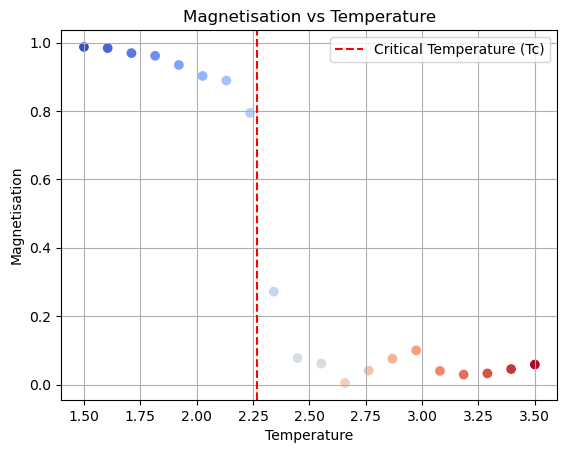

In [21]:
# Calculate the magnetization for each configuration
magnetisations = [np.abs(np.sum(spins)) / L**2 for spins in configurations]

# Plot magnetisation as a function of temperature
plt.scatter(temp_range, magnetisations, c=temp_range, cmap='coolwarm')
plt.xlabel('Temperature')
plt.ylabel('Magnetisation')
plt.title('Magnetisation vs Temperature')

Tc = 2.269  # Critical temperature for 2D Ising model
plt.axvline(x=Tc, color='red', linestyle='--', label='Critical Temperature (Tc)')
plt.grid(True)
plt.legend()
plt.show()


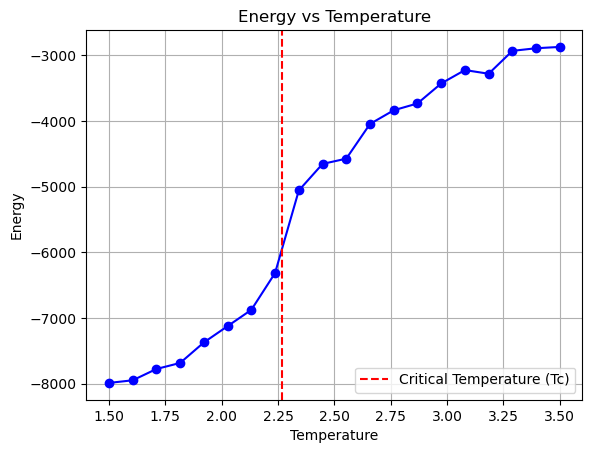

In [19]:
plt.plot(temp_range, average_energies, '-o', color='blue')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs Temperature')
plt.grid(True)
plt.axvline(x=Tc, color='red', linestyle='--', label='Critical Temperature (Tc)')
plt.legend()
plt.show()